In [0]:
import os
import sys
import gym
import numpy as np
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
from collections import deque
from skimage.transform import resize
from skimage.color import rgb2gray
import pylab
from collections import namedtuple


In [15]:
gamma = 0.99
decay_rate = 0.99
learning_rate = 1e-4
batch_size = 10
seed = 87

HEIGHT = 84
WIDTH = 84
HISTORY_SIZE = 4

env = gym.make('BreakoutDeterministic-v4')
# print(env.observation_space.shape[0])
env.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
eps = np.finfo(np.float32).eps.item()

r = []
episodes = []

SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])


/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [0]:
# source: utils.py
def get_frame(X):
    x = np.uint8(resize(rgb2gray(X), (HEIGHT, WIDTH), mode='reflect') * 255)
    return x

def get_init_state(history, s):
    for i in range(HISTORY_SIZE):
        history[i, :, :] = get_frame(s)

In [0]:
# policy net
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc = nn.Linear(3136, 512)
        self.action_head = nn.Linear(512, 3)
        self.value_head  = nn.Linear(512, 1)
        
                     
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.fc(x.view(x.size(0), -1)))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values

In [0]:
# built policy network
policy = Policy()
policy.to(device)

# construct a optimal function
optimizer = optim.RMSprop(policy.parameters(), lr=learning_rate, weight_decay=decay_rate)

In [0]:
# actor-critic agent

def get_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    state = state.to(device)
    probs, state_value = policy(state)

    m = Categorical(probs)
    action = m.sample() 

    saved_actions.append(SavedAction(m.log_prob(action), state_value))

    return action.item()

        
def train_policy_net():
    R = 0
    policy_losses = []
    value_losses = []
    rewards = []
    for r in saved_rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    rewards = torch.tensor(rewards)

    rewards = (rewards - rewards.mean()) / (rewards.std() + eps)
    
    loss = 0
    for (log_prob, value), r in zip(saved_actions, rewards):
      reward = r - value.item()
      policy_losses.append(torch.mul(-log_prob, reward))
      value_losses.append(F.smooth_l1_loss(value, torch.tensor([r]).to(device)))

    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    loss.backward()
    optimizer.step()


episode: 0   score: 1.0    steps: 156     evaluation reward: 1.0
episode 0: model saving...
episode: 1   score: 2.0    steps: 219     evaluation reward: 1.5
episode: 2   score: 1.0    steps: 152     evaluation reward: 1.3333333333333333
episode: 3   score: 1.0    steps: 175     evaluation reward: 1.25
episode: 4   score: 4.0    steps: 295     evaluation reward: 1.8
episode: 5   score: 0.0    steps: 130     evaluation reward: 1.5
episode: 6   score: 5.0    steps: 352     evaluation reward: 2.0
episode: 7   score: 2.0    steps: 207     evaluation reward: 2.0
episode: 8   score: 0.0    steps: 149     evaluation reward: 1.7777777777777777
episode: 9   score: 4.0    steps: 312     evaluation reward: 2.0
episode: 10   score: 0.0    steps: 125     evaluation reward: 1.9
episode: 11   score: 1.0    steps: 182     evaluation reward: 1.8
episode: 12   score: 2.0    steps: 194     evaluation reward: 1.9
episode: 13   score: 4.0    steps: 266     evaluation reward: 2.2
episode: 14   score: 5.0    

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


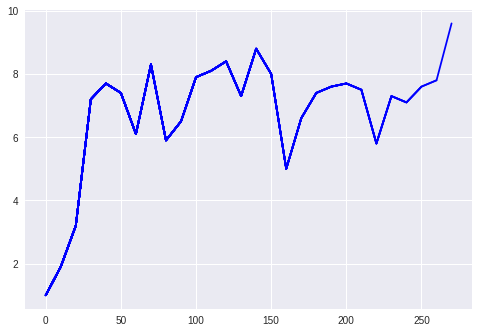

In [19]:
# Main loop
running_reward = None
evaluation_reward = deque(maxlen=10)
for i_episode in range(500000):

    saved_actions = []
    saved_rewards = []
    
    step = 0
    score = 0
    state = env.reset()
    history = np.zeros([5, 84, 84], dtype=np.uint8)
    get_init_state(history, state)
    done = False
    while not done:
        action = get_action(np.float32(history[:4, :, :]) / 255.)

        step += 1
        action = action + 1
        state, reward, done, _ = env.step(action)
        score += reward
        
        saved_rewards.append(np.copy(reward))
        
        
        if done:
            evaluation_reward.append(score)

            print("episode:", i_episode, "  score:", score, "   steps:",  step,
                  "    evaluation reward:", np.mean(evaluation_reward))            

            if np.mean(evaluation_reward) > 10:
              torch.save(policy.state_dict(), 'save_model_png/breakout_a2c.pkl')
              sys.exit()

           

    if i_episode >= 1:
        train_policy_net()

    # Save model in every 50 episode
    if i_episode % 50 == 0:
        print('episode %d: model saving...' % (i_episode))
        torch.save(policy.state_dict(), 'save_model_png/breakout_a2c.pkl')
    if i_episode % 10 == 0:
        r.append(np.mean(evaluation_reward))
        episodes.append(i_episode)
        pylab.plot(episodes, r, 'b')
        pylab.savefig("save_model_png/breakout_a2c.png")

**Reference**:
1. https://github.com/pytorch/examples/blob/master/reinforcement_learning/actor_critic.py
2. https://github.com/jcwleo/Reinforcement_Learning/blob/master/Breakout/Breakout_PolicyGradient.py
3. http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf